# Example of Forecasting a Time Series using a Tree-Based Model

Data set from Kaggle.com (see here https://www.kaggle.com/datasets/bobnau/daily-website-visitors for more details).


In [89]:
import sys, re, time, math
import numpy as np
import pandas as pd
# for time series cross validation
from sklearn.model_selection import TimeSeriesSplit
# for time series decomposition and trend modeling
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
# for Auto-ARIMA
import pmdarima as pm
# for Tree-Based Ensemble
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# for graphing
import plotnine
from plotnine import ggplot, aes, geom_line, geom_smooth, facet_wrap, labs, theme_bw

## Import Data

Read in the CSV file.

This has 2 columns: the date (da) and the target variable (y) which is the number of unique visits.

In [3]:
df = pd.read_csv("./daily-website-visitors.csv")
df["da"] = pd.to_datetime(df["da"])
df["y"] = pd.to_numeric(df["y"])
df.head(10)

,da,y
0,2014-09-14,1582
1,2014-09-15,2528
2,2014-09-16,2630
3,2014-09-17,2614
4,2014-09-18,2366
5,2014-09-19,1863
6,2014-09-20,1118
7,2014-09-21,1656
8,2014-09-22,2586
9,2014-09-23,3257


Plot the data set: X = date and y = number of website visits

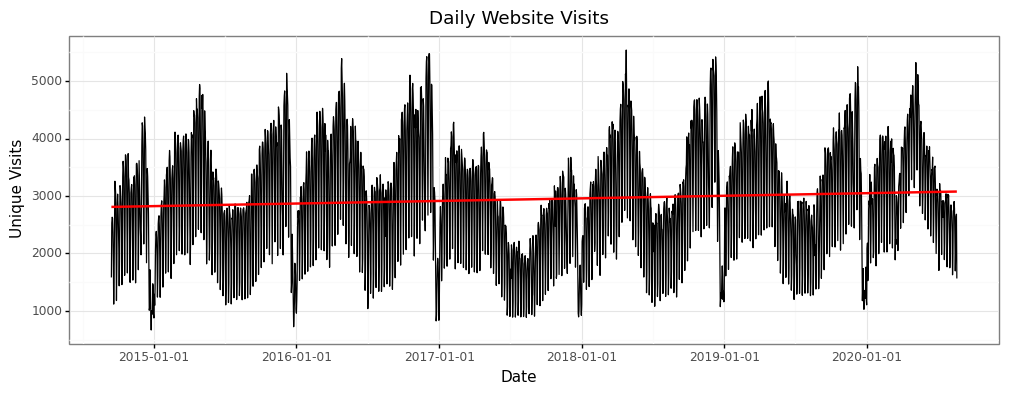

<ggplot: (145787337045)>

In [4]:
plotnine.options.figure_size = (12,4)
(
    ggplot(df, aes(x = "da", y = "y")) +
    geom_line(size=0.5) +
    geom_smooth(se = False, method = "lm", color = "red") +
    labs(x="Date", y="Unique Visits", title="Daily Website Visits") +
    theme_bw()
)

## Holidays

Get US Federal Holidays

 - hd: 1 = holiday, 0 = not holiday
 - bh: 1 = day before holiday, 0 = not day before holiday
 - ah: 1 = day after holiday, 0 = not day after holiday

In [5]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start = df["da"].min(), end = df["da"].max())
df["hd"] = df["da"].isin(holidays).astype(int)           # Holiday
df["bh"] = df["hd"].shift(periods = -1, fill_value = 0)  # Day Before Holiday
df["ah"] = df["hd"].shift(periods = +1, fill_value = 0)  # Day After Holiday
df.head(10)

,da,y,hd,bh,ah
0,2014-09-14,1582,0,0,0
1,2014-09-15,2528,0,0,0
2,2014-09-16,2630,0,0,0
3,2014-09-17,2614,0,0,0
4,2014-09-18,2366,0,0,0
5,2014-09-19,1863,0,0,0
6,2014-09-20,1118,0,0,0
7,2014-09-21,1656,0,0,0
8,2014-09-22,2586,0,0,0
9,2014-09-23,3257,0,0,0


## Calendar Features

Cyclic (i.e. repeating) calendar features plus day number and year.

 - qt: quarter
 - mn: month
 - dy: day of year
 - dm: day of month
 - dw: day of week
 - yr: year
 - dn: day number

In [6]:
df["qt"] = df["da"].dt.quarter     # Quarter of Year: 1=Q1, 2=Q2, ..., 4=Q4
df["mn"] = df["da"].dt.month       # Month of Year: 1=Jan, 2=Feb, ..., 12=Dec
df["dy"] = df["da"].dt.dayofyear   # Day of Year: 1, 2, ..., 366
df["dm"] = df["da"].dt.day         # Day of Month: 1, 2, ..., 31
df["dw"] = df["da"].dt.dayofweek+1 # Day of Week: Mon=1, Tue=2, ..., Sun=7
df["yr"] = df["da"].dt.year        # Year
df["dn"] = df.index+1              # Day Number
df.head(10)

,da,y,hd,bh,ah,qt,mn,dy,dm,dw,yr,dn
0,2014-09-14,1582,0,0,0,3,9,257,14,7,2014,1
1,2014-09-15,2528,0,0,0,3,9,258,15,1,2014,2
2,2014-09-16,2630,0,0,0,3,9,259,16,2,2014,3
3,2014-09-17,2614,0,0,0,3,9,260,17,3,2014,4
4,2014-09-18,2366,0,0,0,3,9,261,18,4,2014,5
5,2014-09-19,1863,0,0,0,3,9,262,19,5,2014,6
6,2014-09-20,1118,0,0,0,3,9,263,20,6,2014,7
7,2014-09-21,1656,0,0,0,3,9,264,21,7,2014,8
8,2014-09-22,2586,0,0,0,3,9,265,22,1,2014,9
9,2014-09-23,3257,0,0,0,3,9,266,23,2,2014,10


## Trigonometric Features

Transform cyclic calendar features to trig (i.e. sine and cosine) format.

In [7]:
df["sdw"] = np.sin(2.0 * np.pi * (df["dw"] - 1) / 7.0)
df["cdw"] = np.cos(2.0 * np.pi * (df["dw"] - 1) / 7.0)
df["sdm"] = np.sin(2.0 * np.pi * (df["dm"] - 1) / df["da"].dt.days_in_month)
df["cdm"] = np.cos(2.0 * np.pi * (df["dm"] - 1) / df["da"].dt.days_in_month)
df["sdy"] = np.sin(2.0 * np.pi * (df["dy"] - 1) / 366.0)
df["cdy"] = np.cos(2.0 * np.pi * (df["dy"] - 1) / 366.0)
df["smn"] = np.sin(2.0 * np.pi * (df["mn"] - 1) / 12.0)
df["cmn"] = np.cos(2.0 * np.pi * (df["mn"] - 1) / 12.0)
df["sqt"] = np.sin(2.0 * np.pi * (df["qt"] - 1) / 4.0)
df["cqt"] = np.cos(2.0 * np.pi * (df["qt"] - 1) / 4.0)
df.head()

,da,y,hd,bh,ah,qt,mn,dy,dm,dw,...,sdw,cdw,sdm,cdm,sdy,cdy,smn,cmn,sqt,cqt
0,2014-09-14,1582,0,0,0,3,9,257,14,7,...,-0.781831,0.623490,4.067366e-01,-0.913545,-0.949990,-0.312281,-0.866025,-0.5,1.224647e-16,-1.0
1,2014-09-15,2528,0,0,0,3,9,258,15,1,...,0.000000,1.000000,2.079117e-01,-0.978148,-0.955211,-0.295927,-0.866025,-0.5,1.224647e-16,-1.0
2,2014-09-16,2630,0,0,0,3,9,259,16,2,...,0.781831,0.623490,5.665539e-16,-1.000000,-0.960150,-0.279486,-0.866025,-0.5,1.224647e-16,-1.0
3,2014-09-17,2614,0,0,0,3,9,260,17,3,...,0.974928,-0.222521,-2.079117e-01,-0.978148,-0.964806,-0.262962,-0.866025,-0.5,1.224647e-16,-1.0
4,2014-09-18,2366,0,0,0,3,9,261,18,4,...,0.433884,-0.900969,-4.067366e-01,-0.913545,-0.969178,-0.246361,-0.866025,-0.5,1.224647e-16,-1.0


## Covariates / Features

Put calendar features in a list for easy data set subsetting.

In [8]:
x_vars = [
    "hd","bh","ah", # Holiday Features
    "qt","mn","dy","dm","dw","yr","dn", # Calendar Features
    "sqt","cqt","smn","cmn","sdy","cdy","sdm","cdm","sdw","cdw" # Trig Features
]
print(x_vars)

['hd', 'bh', 'ah', 'qt', 'mn', 'dy', 'dm', 'dw', 'yr', 'dn', 'sqt', 'cqt', 'smn', 'cmn', 'sdy', 'cdy', 'sdm', 'cdm', 'sdw', 'cdw']


## Time Series Split

Create time series splits. These are used to evaluate forecast accuracy.

- n_splits: the number of time series splits (similar to k in k-fold cross-validation)
- test_size: the number of observations in the test split (i.e. forecast horizon)
- max_train_size: the maximum number of observations in the train split
- gap: how much gap (measured in number of time steps) between splits

In [9]:
n_splits = 4
test_size = 365
ts_split = TimeSeriesSplit(
    n_splits=n_splits,  
    test_size=test_size,
    gap=0
)
all_splits = list(ts_split.split(df))
ts_split

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=365)

## Function to convert seconds to hours minutes seconds

Used for timing of various operations.

In [10]:
def sec_to_hms(secs):
    m, s = divmod(secs, 60)
    h, m = divmod(m, 60)
    h_str = "%d"   % int(h)
    m_str = "%02d" % int(m)
    s_str = "%02.2f" % round(s,2)
    s_str = re.sub(r'\.00$','',s_str)
    return ':'.join([h_str,m_str,s_str])

## Trend: Fit and Forecast

Fit a trend to the training split, then forecast (predict) the trend for the testing split. 

**Note:** The choice for what method to use to fit (and forecast) the trend could vary, and different methods could be applied to each step.

For this data set, we use STLForecast to modeling the trend

This code block loops thru the time series splits and returns a data frame for each split with:
 - the actual target values for the training split (for plotting and de-trending)
 - the fitted trend to the training split
 - the forecasted trend in the testing split

In [46]:
n_trend = 9999 # days for trend parameter in STL()
n_lags = 1 # days for lags parameter in AutoReg()
df_trend_results = pd.DataFrame() # data frame to hold the results
for split in np.arange(0, n_splits): # loop thru the splits
    t1 = time.time()
    train_index, test_index = all_splits[split] # train/test indices
    endog_train = df.loc[train_index, ["da","y"]].set_index("da").squeeze().asfreq("D") # training split (past)
    stl = STL(endog=endog_train, period=7, trend=n_trend).fit() # decompose to extract the trend
    df_trend_act = pd.DataFrame({"trend":endog_train}) # save actual values
    df_trend_act["split"] = split
    df_trend_act["type"] = "actual"
    df_trend_fit = pd.DataFrame(stl.trend) # save fitted trend
    df_trend_fit["split"] = split
    df_trend_fit["type"] = "fitted"
    trend_mod = AutoReg(endog=stl.trend, lags=n_lags, trend="t", seasonal=True, period=7).fit() # model the trend
    trend_fore = trend_mod.predict(start=np.min(test_index), end=np.max(test_index)) # testing split (future) trend forecast
    df_trend_fore = pd.DataFrame({"trend":trend_fore}) # save forecasted trend
    df_trend_fore["split"] = split
    df_trend_fore["type"] = "forecast"
    df_trend_results = pd.concat([ # collect results for each split
        df_trend_results, 
        df_trend_act.reset_index().rename(columns={"index":"da"}),                       # actual values (past)
        df_trend_fit.reset_index(),                                                      # fitted trend (past)
        df_trend_fore.reset_index().rename(columns={"index":"da"}).set_index(test_index) # forecasted trend (future)
    ])
    seconds = time.time() - t1
    print("De-trending time for split", split, sec_to_hms(seconds))

De-trending time for split 0 0:00:0.49
De-trending time for split 1 0:00:0.62
De-trending time for split 2 0:00:1.03
De-trending time for split 3 0:00:1.66


## Plot the Trend

Plot the trend, both fit to past and forecast in future, for each time series split.

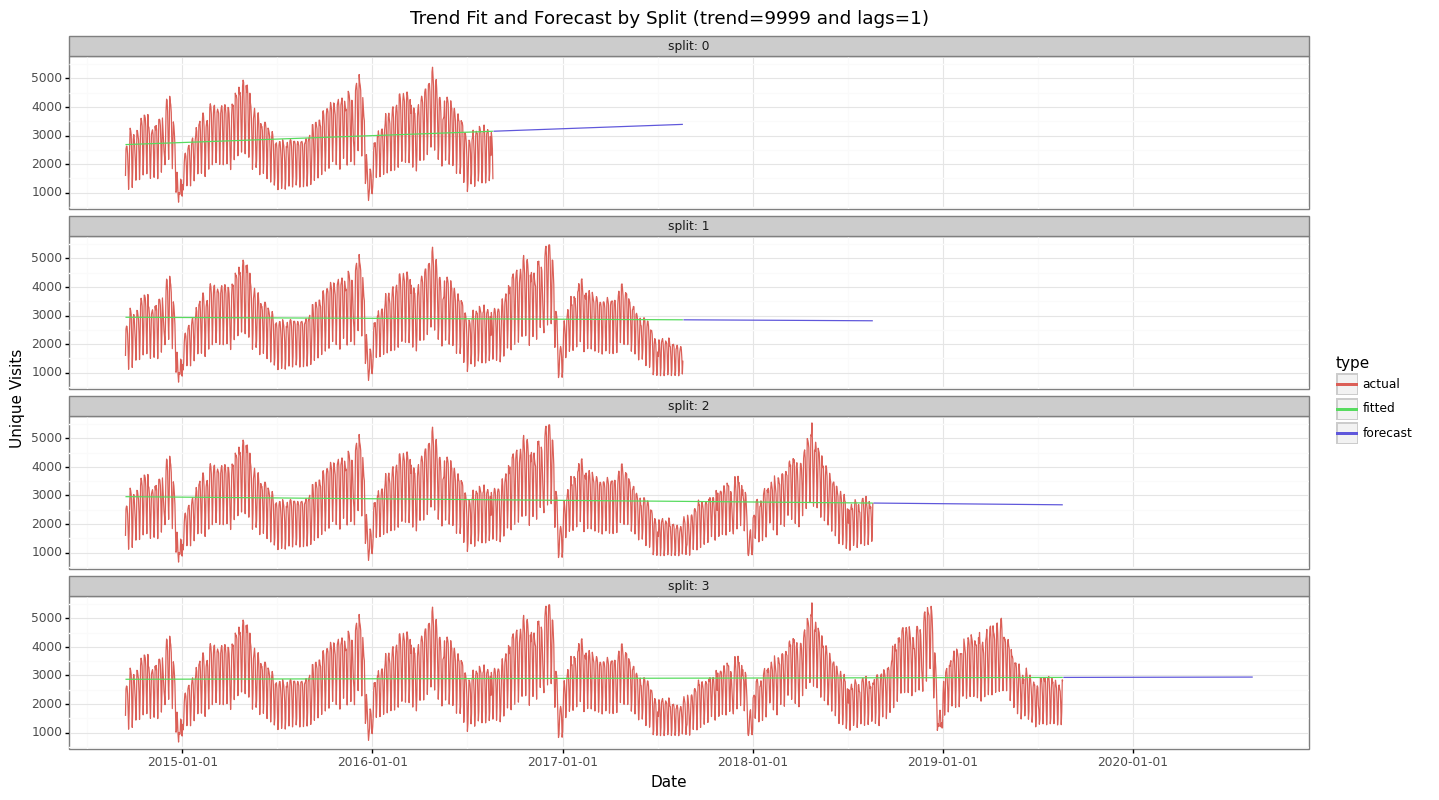

<ggplot: (145795978382)>

In [47]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_trend_results, aes("da", "trend", color="type")) +
    geom_line() +
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x="Date", y="Unique Visits", title="Trend Fit and Forecast by Split (trend=" + str(n_trend) + " and " + "lags=" + str(n_lags) + ")") +
    theme_bw()
)


## De-Trend the Time Series

De-trend the time series so that we can train the tree-based model on the data without needing to worry if the forecast horizon will extrapolate outside the range of values seen in the training data.

In [39]:
df_detrend_results = pd.DataFrame()
for split in np.arange(0, n_splits):
    t1 = time.time()
    train_index, test_index = all_splits[split]
    x_train = np.ravel(df.loc[train_index, ["da"]])
    x_test = np.ravel(df.loc[test_index, ["da"]])
    y_train = np.ravel(df.loc[train_index, ["y"]])
    y_trend = np.ravel(df_trend_results.query("split==@split and type=='fitted'")["trend"])
    df_calc = pd.DataFrame({
        "split": split,
        "da": x_train,
        "detrend": y_train - y_trend
    })
    df_detrend_results = pd.concat([df_detrend_results, df_calc])
    seconds = time.time() - t1
    print("Detrending for split", split, sec_to_hms(seconds))

Detrending for split 0 0:00:0.01
Detrending for split 1 0:00:0.01
Detrending for split 2 0:00:0.01
Detrending for split 3 0:00:0.01


## Plot the Detrended Time Series

Note that cyclic patterns still exist.

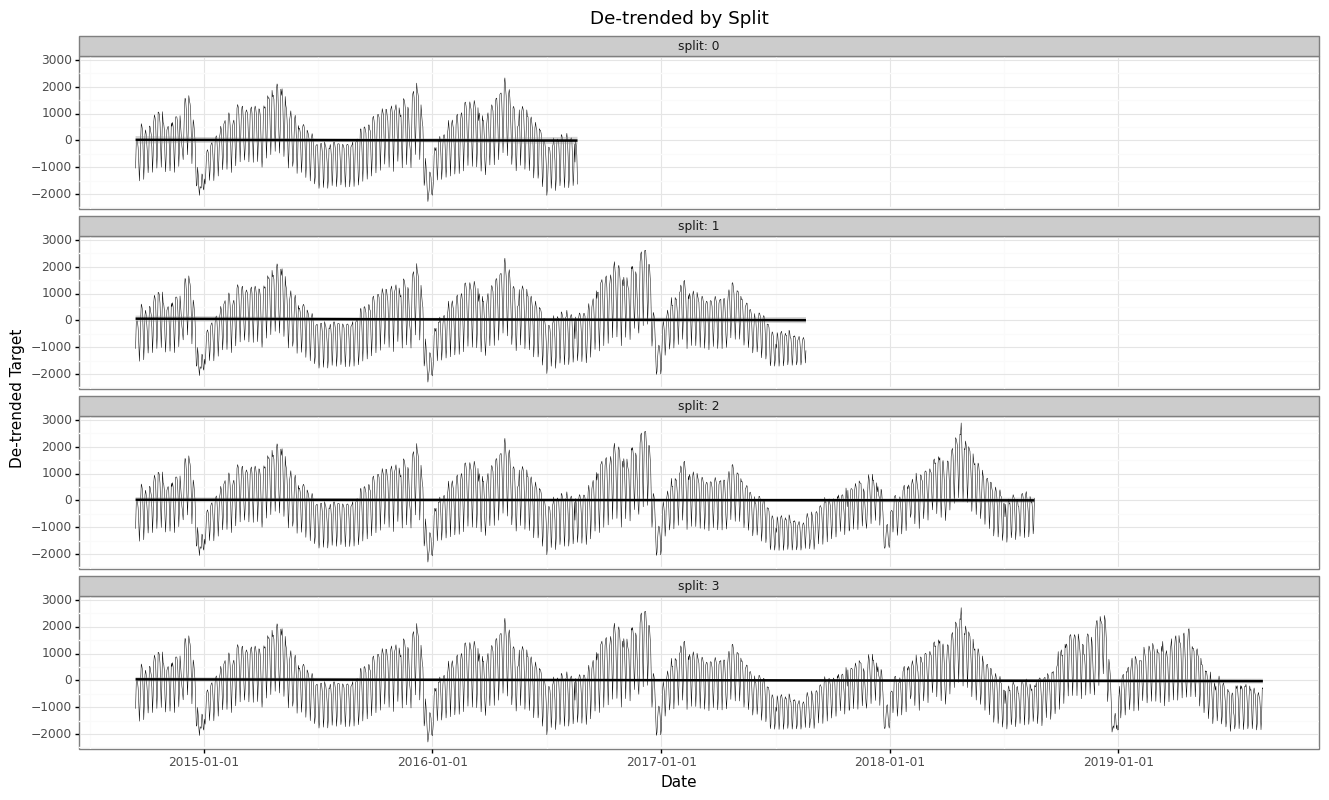

<ggplot: (145796086718)>

In [40]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_detrend_results, aes("da", "detrend")) +
    geom_line(size=0.2) +
    geom_smooth() +
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x = "Date", y = "De-trended Target", title = "De-trended by Split") +
    theme_bw()
)

## Fit a Tree-Based Model

Train a tree-based model on the de-trended time series. 

Note: a benefit of using a tree-based ensemble algo is that we can include many cyclic features (i.e. date/time components) without worrying too much about spurious or correlated features.

Alternative to use xgboost library. We tried, but got the same results as scikit-learn implementation.

In [120]:
df_tree_pred = pd.DataFrame()
n_est = 100
msl = 0.002
max_f = 0.8
mss = 0.005
for split in np.arange(0, n_splits):
    # Extreme Random Trees
    ert_pipe = make_pipeline(
       MaxAbsScaler(),
       ExtraTreesRegressor(bootstrap=False, max_features=max_f, min_samples_leaf=msl, min_samples_split=mss, n_estimators=n_est)
    )
    # Light XGBoost
    hist_xgb_pipe = make_pipeline(
       MaxAbsScaler(),
       HistGradientBoostingRegressor(learning_rate=0.1, l2_regularization=0.1, max_iter=n_est)
    )
    # Random Forests
    rf_pipe = make_pipeline(
       MaxAbsScaler(),
       RandomForestRegressor(bootstrap=False, max_features=max_f, min_samples_leaf=msl, min_samples_split=mss, n_estimators=n_est)
    )
    train_index, test_index = all_splits[split] # train/test splits
    x_train = df.loc[train_index, x_vars]
    x_test = df.loc[test_index, x_vars]
    y_train = np.ravel(df_detrend_results.query("split==@split")["detrend"])
    df_tree_train_split = df.loc[train_index,["da"]].copy() # save actual values
    df_tree_train_split["y"] = y_train
    df_tree_train_split["split"] = split
    df_tree_train_split["type"] = "actual"
    df_tree_train_split["trend"] = np.ravel(df_trend_results.query("split==@split and type=='fitted'")["trend"])
    # fit ERT model
    t1 = time.time(); ert_pipe.fit(X = x_train, y = y_train); seconds_ert = time.time() - t1
    df_tree_pred_ert = df.loc[test_index,["da"]].copy() # save ERT predictions
    df_tree_pred_ert["y"] = ert_pipe.predict(X = x_test)
    df_tree_pred_ert["split"] = split
    df_tree_pred_ert["type"] = "ERT"
    df_tree_pred_ert["trend"] = np.ravel(df_trend_results.query("split==@split and type=='forecast'")["trend"])
    # fit Light XGB model
    t1 = time.time(); hist_xgb_pipe.fit(X = x_train, y = y_train); seconds_xgb = time.time() - t1
    df_tree_pred_xgb = df.loc[test_index,["da"]].copy() # save XGB predictions
    df_tree_pred_xgb["y"] = hist_xgb_pipe.predict(X = x_test)
    df_tree_pred_xgb["split"] = split
    df_tree_pred_xgb["type"] = "LightGBM"
    df_tree_pred_xgb["trend"] = np.ravel(df_trend_results.query("split==@split and type=='forecast'")["trend"])
    # fit RF model
    t1 = time.time(); rf_pipe.fit(X = x_train, y = y_train); seconds_rf = time.time() - t1
    df_tree_pred_rf = df.loc[test_index,["da"]].copy() # save RF predictions
    df_tree_pred_rf["y"] = rf_pipe.predict(X = x_test)
    df_tree_pred_rf["split"] = split
    df_tree_pred_rf["type"] = "RF"
    df_tree_pred_rf["trend"] = np.ravel(df_trend_results.query("split==@split and type=='forecast'")["trend"])
    # collect across all splits
    df_tree_pred = pd.concat([
        df_tree_pred, df_tree_train_split, df_tree_pred_ert, df_tree_pred_xgb, df_tree_pred_rf
    ]) 
    print(
        "Training time for split", split, "(ERT, LightGBM, RF): (", 
        sec_to_hms(seconds_ert), ",", sec_to_hms(seconds_xgb), ",", sec_to_hms(seconds_rf), ")"
    )

Training time for split 0 (ERT, LightGBM, RF): ( 0:00:0.15 , 0:00:0.61 , 0:00:0.33 )
Training time for split 1 (ERT, LightGBM, RF): ( 0:00:0.17 , 0:00:0.69 , 0:00:0.51 )
Training time for split 2 (ERT, LightGBM, RF): ( 0:00:0.22 , 0:00:0.72 , 0:00:0.59 )
Training time for split 3 (ERT, LightGBM, RF): ( 0:00:0.25 , 0:00:0.71 , 0:00:0.72 )


Plot the tree-model forecasts/predictions.

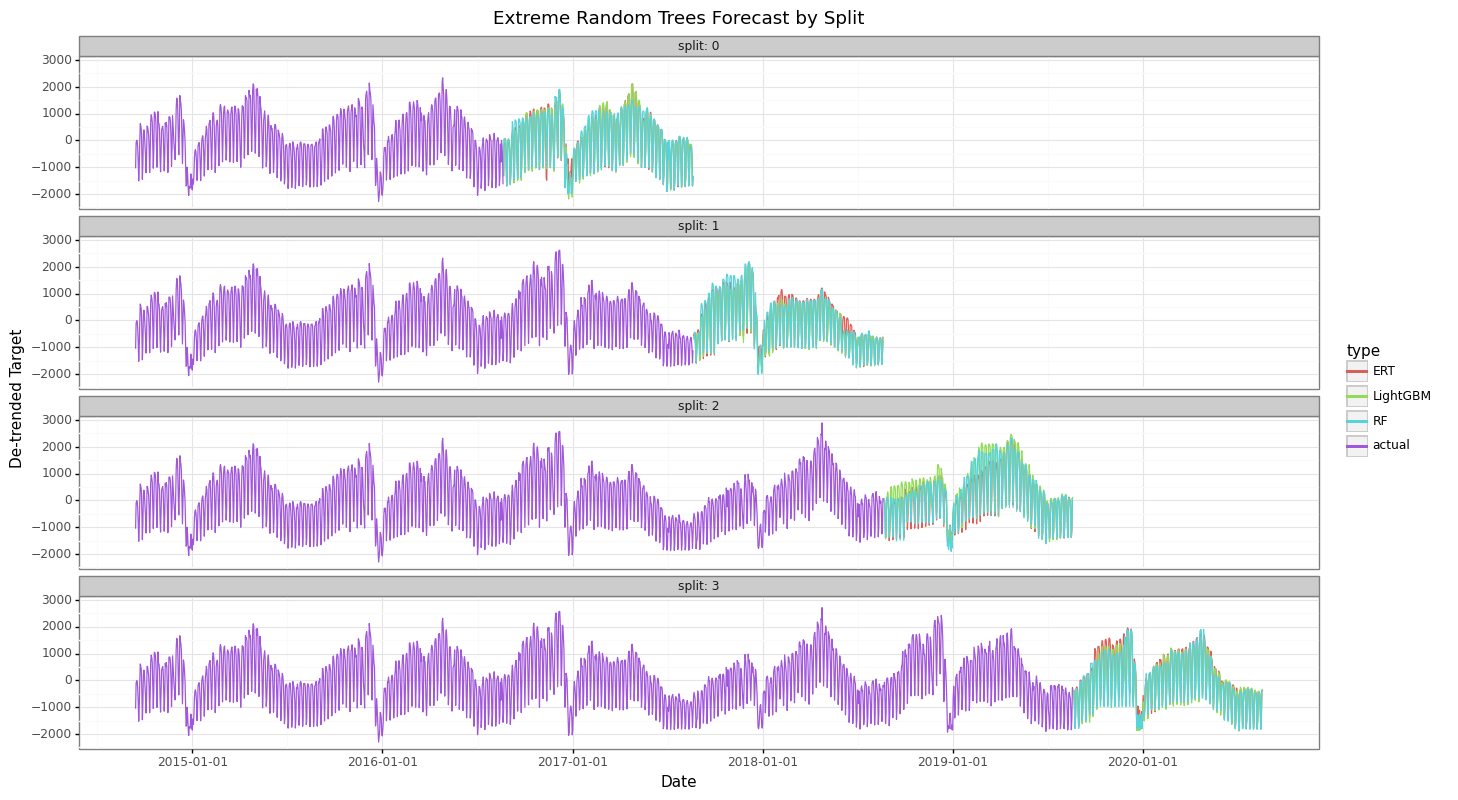

<ggplot: (145799779768)>

In [121]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_tree_pred, aes("da", "y", color="type")) +
    geom_line(size=0.5) +
    #geom_smooth() +
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x = "Date", y = "De-trended Target", title = "Extreme Random Trees Forecast by Split") +
    theme_bw()
)

## Combine Forecasts

Combine the trend forecast and the tree-model forecast for each split.

In [122]:
df_forecast_all = df_tree_pred.copy()
df_forecast_all["combined"] = df_forecast_all["trend"] + df_forecast_all["y"]
df_forecast_all

,da,y,split,type,trend,combined
0,2014-09-14,-1039.395865,0,actual,2682.915012,1643.519147
1,2014-09-15,-94.327525,0,actual,2683.578643,2589.251118
2,2014-09-16,6.741078,0,actual,2684.242264,2690.983342
3,2014-09-17,-10.190057,0,actual,2684.905877,2674.715820
4,2014-09-18,-259.120929,0,actual,2685.569480,2426.448551
...,...,...,...,...,...,...
2162,2020-08-15,-1823.787494,3,RF,2942.411779,1118.624285
2163,2020-08-16,-1421.159536,3,RF,2942.443425,1521.283889
2164,2020-08-17,-375.318012,3,RF,2942.475056,2567.157044
2165,2020-08-18,-375.318012,3,RF,2942.506680,2567.188668


Plot the forecasts

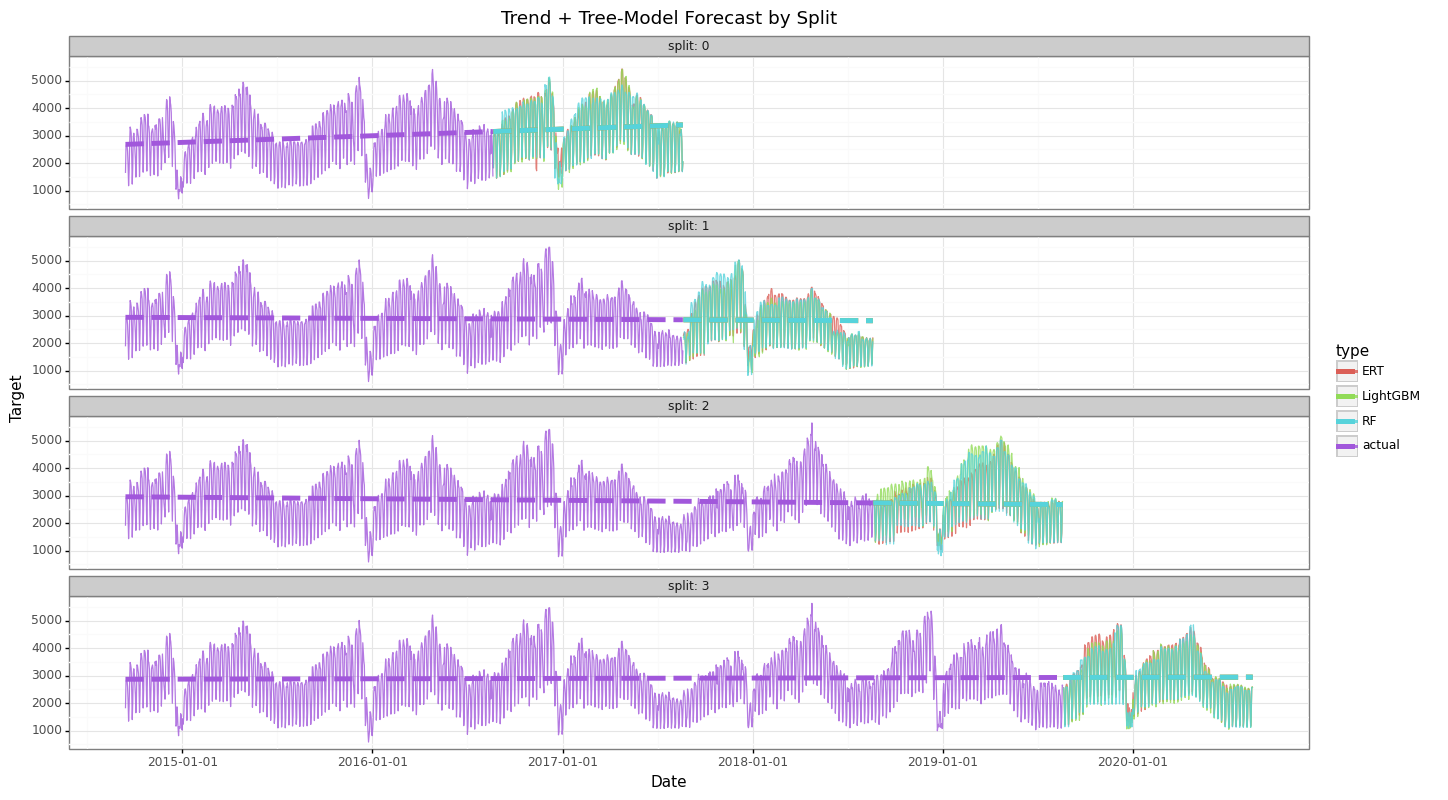

<ggplot: (145798552899)>

In [123]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_forecast_all, aes("da", "combined", color="type")) +
    geom_line(size=0.5, alpha=0.8) +
    geom_line(aes(y="trend"), linetype="dashed", size=2) +
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x = "Date", y = "Target", title = "Trend + Tree-Model Forecast by Split") +
    theme_bw()
)

In [88]:
df_arima_results = pd.DataFrame()
for split in np.arange(0, len(all_splits)):
    t1 = time.time()
    train_index, test_index = all_splits[split]
    endog_train = df.loc[train_index, ["y"]] # training endog
    exog_train = df.loc[train_index, x_vars] # training exog
    ar_model = pm.auto_arima(y=endog_train, exogenous=exog_train, seasonal=True, D=1, m=7, stepwise=True, maxiter=10) # Auto-ARIMA procedure
    ar_pred = ar_model.predict(n_periods=len(test_index), X=df.loc[test_index, x_vars]) # make forecasts
    df_arima_fore = pd.DataFrame({"da": np.ravel(df.loc[test_index, ["da"]]), "y":ar_pred, "split":split, "type":"forecast"}) # save forecasts
    df_arima_past = pd.DataFrame({"da": np.ravel(df.loc[train_index, ["da"]]), "y":np.ravel(endog_train.values), "split":split, "type":"actual"}) # save actuals (past)
    df_arima_results = pd.concat([df_arima_results, df_arima_past, df_arima_fore], axis=0) # collect results across splits
    seconds = time.time() - t1
    print("Split", split, "training time =", sec_to_hms(seconds))

Split 0 training time = 0:02:39.95
Split 1 training time = 0:02:10.78
Split 2 training time = 0:02:4.98
Split 3 training time = 0:02:20.13


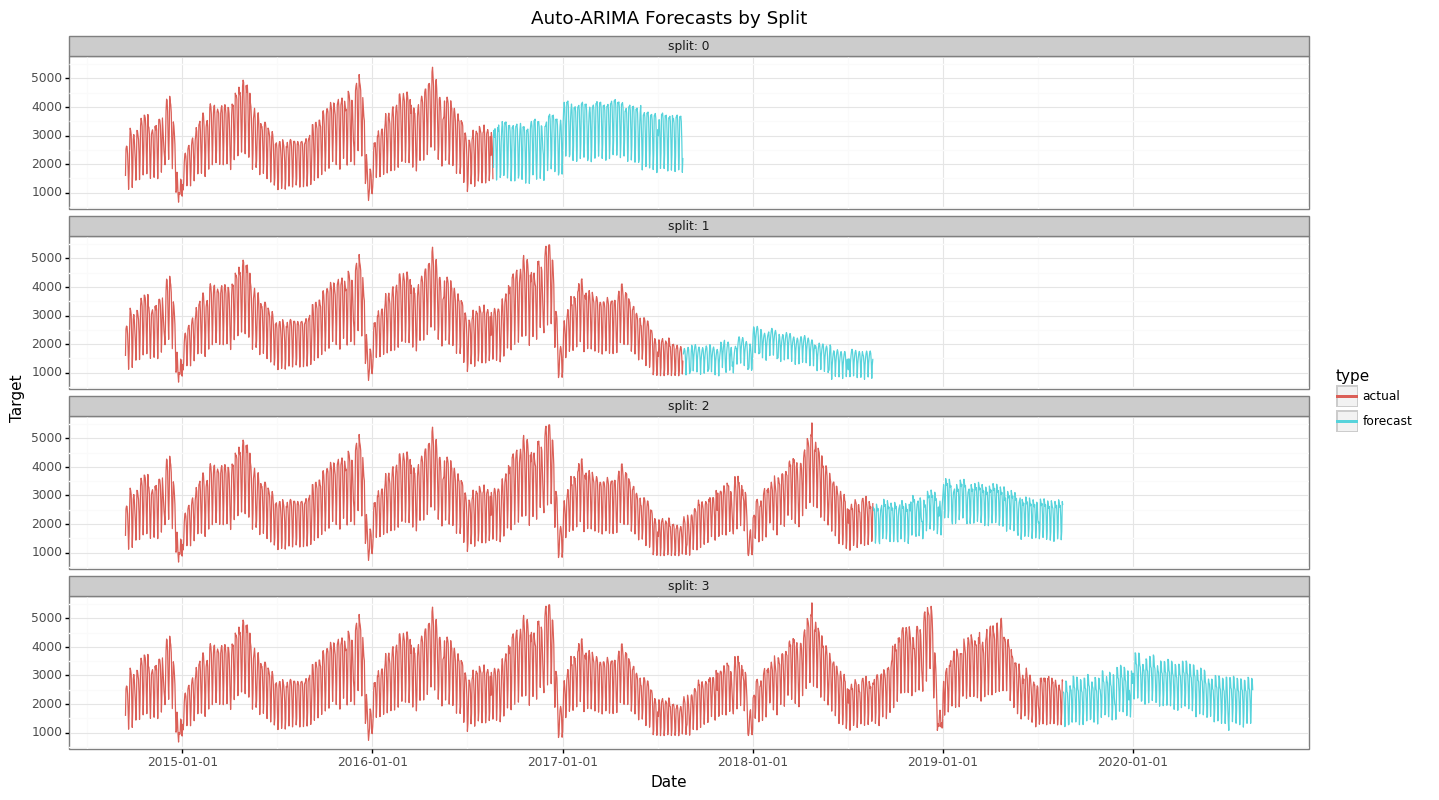

<ggplot: (138506376933)>

In [23]:
plotnine.options.figure_size = (16,9)
(
    ggplot(df_arima_results, aes("da", "y", color="type")) +
    geom_line(size=0.5) +
    facet_wrap("~split", ncol=1, labeller="label_both") +
    labs(x = "Date", y = "Target", title = "Auto-ARIMA Forecasts by Split") +
    theme_bw()
)

## Forecast Error 

Use Lev's custom error function to calculate the forecast error.

See this [repo](https://github.com/lselector/statistics/blob/master/nb_Time_Series_Forecast_Error.ipynb) for more details.

In [35]:
from sklearn.metrics import mean_squared_error
# Function from Lev's Repo
def fin_err(actual, 
            predicted, 
            norm=None,
            err_type='mae',   # mae or rmse
            noise_level_relative=1e-2,
            noise_level_absolute=1e-2,
            max_error=1e2):
    """
    # calculate relative difference 
    # between two arrays (or lists): actual & predicted
    # fin_err() is similar to normalized_mean_absolute_error
    # but optimized for financial data.
    # It takes into account not only amplitude of oscillations,
    # but also the "level" of values.
    # It also limits maximum error in cases when 
    # actual signal doesn't change much
    # optional parameters:
    #   norm (when provided) used as denominator
    #   noise_level_relative (default 0.01)
    #   noise_level_absolute (default 0.01)
    #   max_error (default 100.0)
    """
    Na, Np = len(actual), len(predicted)
    if Na == 0 or Np == 0 or Na != Np:
        return np.nan
    np_act = np.array(actual, dtype = np.float64)
    np_pre = np.array(predicted, dtype = np.float64)
    if err_type == 'mae': # Mean Absolute Error
        myerr = np.abs(np_act - np_pre).sum() / Na
    elif err_type == 'rmse': # Root Mean Square Error
        myerr = math.sqrt(mean_squared_error(np_act, np_pre)) 
    else:
        print("ERROR: err_type should be 'mae' or 'rmse', exiting ...")
        sys.exit(1)
    if norm and norm > 0: # normalize - and limit
        return min (max_error, myerr / norm )  
    v_max_act, v_min_act = np.max(np_act), np.min(np_act) # max min   
    v_max_pre, v_min_pre = np.max(np_pre), np.min(np_pre) # max min  
    v_amp_act   = v_max_act - v_min_act        # amplitude      
    v_amp_pre   = v_max_pre - v_min_pre        # amplitude      
    v_level_act = np.abs(np_act).sum() / Na    # level             
    v_scale_act = max(v_level_act, v_amp_act)  # level
    v_level_pre = np.abs(np_pre).sum() / Na    # scale             
    v_scale_pre = max(v_level_pre, v_amp_pre)  # scale
    if (v_scale_act <= noise_level_absolute and 
        v_scale_pre <= noise_level_absolute):
            return 0 # actual and predicted are both close to zero 
    denom_min = max(v_scale_act * noise_level_relative,
                    noise_level_absolute)
    if v_scale_act > denom_min :
        denom = v_scale_act
    else:
        denom = denom_min
    return min (max_error, (myerr / denom))

In [126]:
y_actual = np.ravel(df.tail(test_size*n_splits)["y"])
y_pred_tree_ert = np.ravel(df_forecast_all.query("type=='ERT'").loc[:,["combined"]])
y_pred_tree_gbm = np.ravel(df_forecast_all.query("type=='LightGBM'").loc[:,["combined"]])
y_pred_tree_rf = np.ravel(df_forecast_all.query("type=='RF'").loc[:,["combined"]])
y_pred_arima = np.ravel(df_arima_results.query("type=='forecast'").loc[:,["y"]])
ert_error = fin_err(actual=y_actual, predicted=y_pred_tree_ert, err_type="rmse")
gbm_error = fin_err(actual=y_actual, predicted=y_pred_tree_gbm, err_type="rmse")
rf_error = fin_err(actual=y_actual, predicted=y_pred_tree_rf, err_type="rmse")
arima_error = fin_err(actual=y_actual, predicted=y_pred_arima, err_type="rmse")
print(f"       ERT Model = {np.round(100*ert_error, 2)}" + "%")
print(f"  LightGBM Model = {np.round(100*gbm_error, 2)}" + "%")
print(f"        RF Model = {np.round(100*rf_error, 2)}" + "%")
print(f"Auto-ARIMA Model = {np.round(100*arima_error, 2)}" + "%")

       ERT Model = 13.67%
  LightGBM Model = 13.47%
        RF Model = 14.45%
Auto-ARIMA Model = 21.55%
